# Introduction to PyTorch Part 3

> by Habib Bukhari and Roman Vaxenburg

```python 
#only on colab
#Run once per session
!pip install fastai -q --upgrade
```

make sure your `gpu` is working navigate to `Edit` -> `Notebook settings` - > `Hardware accelerator` and select `GPU` click `SAVE`

In [50]:
#downloading the data
from fastai.vision.all import untar_data, URLs, Path, show_image, get_image_files
from fastai.vision.all import DataLoaders, DataLoader
import PIL
import re
import random
import pandas as pd
!pip install fastdot -q
from fastdot import *
import numpy as np
import torch
import matplotlib.pyplot as plt

# Setting up Project 

We will be working with `The Oxford-IIIT PET Dataset` 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. https://www.robots.ox.ac.uk/~vgg/data/pets/ 

## 1. Downloading Data

In [51]:
path = untar_data(URLs.PETS)

In [52]:
path

Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet')

In [53]:
list_of_all_images = list(Path(path/'images').iterdir())

In [54]:
list_of_all_images[:5]

[Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Bombay_118.jpg'),
 Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Siamese_165.jpg'),
 Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_31.jpg'),
 Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/great_pyrenees_21.jpg'),
 Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/basset_hound_48.jpg')]

In [55]:
print (f'total number of images: {len(list_of_all_images)}')

total number of images: 4520


In [56]:
one_file_name = random.choice(list_of_all_images); one_file_name

Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/beagle_122.jpg')

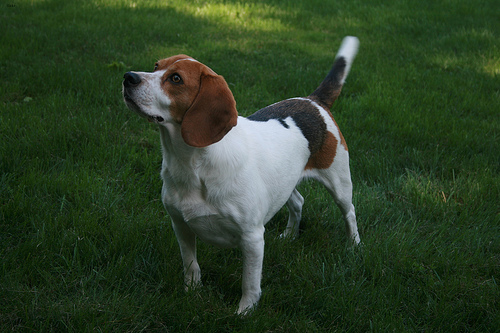

In [57]:
#lets open an image
PIL.Image.open(one_file_name)

In [58]:
#lets try to see what label
one_file_name.name

'beagle_122.jpg'

In [59]:
#this label contain numbers lets make it a bit pretty

In [60]:
pattern = r'([^/]+)_\d+.*$'

In [61]:
re.search(pattern, one_file_name.name).groups()

('beagle',)

In [62]:
def get_label(fn: Path, pattern = r'([^/]+)_\d+.*$'):
    label = re.search(pattern, fn.name).groups()[0]
    return label

def open_image(fn: Path):
    return PIL.Image.open(fn)

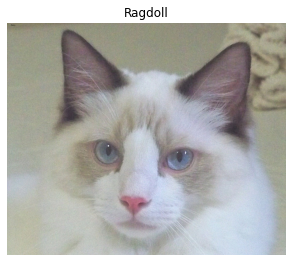

In [63]:
fn = random.choice(list_of_all_images)
show_image(open_image(fn), title = get_label(fn))

In [64]:
#lets organize a bit data make a nice csv file with filenames and labels

In [65]:
list_of_all_images = get_image_files(path)
train_df = pd.DataFrame({'fn': list_of_all_images, 'labels': [get_label(i) for i in list_of_all_images]})

In [66]:
train_df

,fn,labels
0,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Bombay_118.jpg,Bombay
1,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Siamese_165.jpg,Siamese
2,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_31.jpg,english_cocker_spaniel
3,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/great_pyrenees_21.jpg,great_pyrenees
4,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/basset_hound_48.jpg,basset_hound
...,...,...
4513,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Russian_Blue_110.jpg,Russian_Blue
4514,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/saint_bernard_56.jpg,saint_bernard
4515,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_182.jpg,miniature_pinscher
4516,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/american_bulldog_108.jpg,american_bulldog


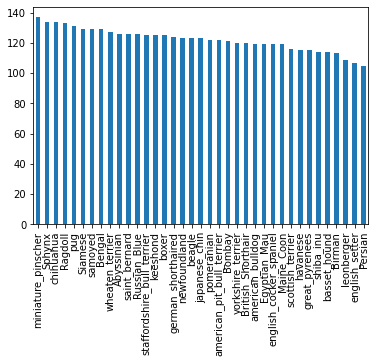

In [67]:
#seems like we have pretty even distribution
train_df['labels'].value_counts().plot.bar()

## 2. Preparing Labels


Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.In general, this is mostly a constraint of the efficient implementation of machine learning algorithms rather than hard limitations on the algorithms themselves.This means that categorical data must be converted to a numerical form. If the categorical variable is an output variable, you may also want to convert predictions by the model back into a categorical form in order to present them or use them in some application. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [68]:
label_to_int = {lbl: num for num, lbl in enumerate(train_df['labels'].unique())}

In [69]:
label_to_int

{'Bombay': 0,
 'Siamese': 1,
 'english_cocker_spaniel': 2,
 'great_pyrenees': 3,
 'basset_hound': 4,
 'saint_bernard': 5,
 'Persian': 6,
 'Birman': 7,
 'leonberger': 8,
 'beagle': 9,
 'Abyssinian': 10,
 'english_setter': 11,
 'shiba_inu': 12,
 'german_shorthaired': 13,
 'Russian_Blue': 14,
 'yorkshire_terrier': 15,
 'american_bulldog': 16,
 'newfoundland': 17,
 'wheaten_terrier': 18,
 'British_Shorthair': 19,
 'staffordshire_bull_terrier': 20,
 'pomeranian': 21,
 'Ragdoll': 22,
 'havanese': 23,
 'Sphynx': 24,
 'miniature_pinscher': 25,
 'american_pit_bull_terrier': 26,
 'boxer': 27,
 'japanese_chin': 28,
 'Bengal': 29,
 'chihuahua': 30,
 'pug': 31,
 'keeshond': 32,
 'Maine_Coon': 33,
 'Egyptian_Mau': 34,
 'samoyed': 35,
 'scottish_terrier': 36}

In [70]:
#reverse dictonary
int_to_label =  {v: k for k, v in label_to_int.items()}
int_to_label

{0: 'Bombay',
 1: 'Siamese',
 2: 'english_cocker_spaniel',
 3: 'great_pyrenees',
 4: 'basset_hound',
 5: 'saint_bernard',
 6: 'Persian',
 7: 'Birman',
 8: 'leonberger',
 9: 'beagle',
 10: 'Abyssinian',
 11: 'english_setter',
 12: 'shiba_inu',
 13: 'german_shorthaired',
 14: 'Russian_Blue',
 15: 'yorkshire_terrier',
 16: 'american_bulldog',
 17: 'newfoundland',
 18: 'wheaten_terrier',
 19: 'British_Shorthair',
 20: 'staffordshire_bull_terrier',
 21: 'pomeranian',
 22: 'Ragdoll',
 23: 'havanese',
 24: 'Sphynx',
 25: 'miniature_pinscher',
 26: 'american_pit_bull_terrier',
 27: 'boxer',
 28: 'japanese_chin',
 29: 'Bengal',
 30: 'chihuahua',
 31: 'pug',
 32: 'keeshond',
 33: 'Maine_Coon',
 34: 'Egyptian_Mau',
 35: 'samoyed',
 36: 'scottish_terrier'}

In [71]:
#convert text to numerical
train_df['labels'] = train_df['labels'].map(label_to_int)
train_df.head()

,fn,labels
0,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Bombay_118.jpg,0
1,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/Siamese_165.jpg,1
2,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_31.jpg,2
3,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/great_pyrenees_21.jpg,3
4,/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/basset_hound_48.jpg,4


## 3. Splitting Data in to `training` and `validation`

In [72]:
#why its important to split

In [73]:
train_df.shape

(4518, 2)

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
x_train, x_test, y_train, y_test = train_test_split(train_df['fn'].values, 
                                                    train_df['labels'].values, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=train_df['labels'].values)

In [76]:
#lets make a nice csv with training and valid
training_df = pd.DataFrame({'fn': x_train, 'labels': y_train})
valid_df    = pd.DataFrame({'fn': x_test,  'labels': y_test})

In [77]:
training_df.shape

(3614, 2)

In [78]:
valid_df.shape

(904, 2)

## 4. Building `dataset` and `dataloader`

In [79]:
fn = valid_df.iloc[0]['fn']; fn

Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_27.jpg')

In [80]:
fn

Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_27.jpg')

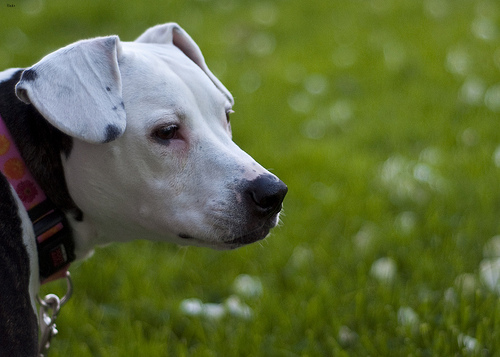

In [81]:
img = PIL.Image.open(fn)
img

In [82]:
img.size

(500, 357)

In [85]:
def get_size(fn: Path):
    return PIL.Image.open(fn).size

training_df['size'] = training_df['fn'].map(get_size)

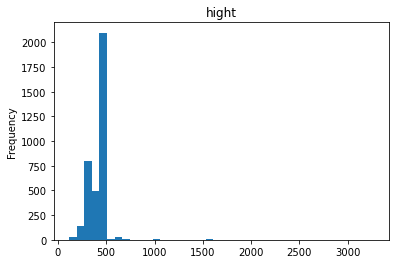

In [102]:
training_df['size'].apply(lambda x: x[0]).plot.hist(bins=40, title='hight')

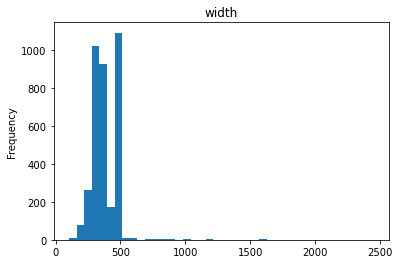

In [103]:
training_df['size'].apply(lambda x: x[1]).plot.hist(bins=40, title='width')

we have diffrent size of images ... CNN network works very efficiently only on rectangale images so we have to convert all images to equal size. https://stackoverflow.com/questions/38972156/why-are-inputs-for-convolutional-neural-networks-always-squared-images

In [107]:
#lets write the function which can help us achive this 
def open_image(fn: Path, sz: int = 224):
    img = PIL.Image.open(fn)
    img = img.resize((sz, sz))
    return img

In [108]:
img = open_image(fn)

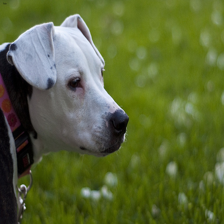

In [109]:
img

In [110]:
img.size == (224, 224)

True

###  Transfer Learning
https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score. he reason we do both of those things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model. e'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier). nother way you can think about it is deep learning networks traditionally share many parameters - if you didn't scale your inputs in a way that resulted in similarly-ranged feature values (ie: over the whole dataset by subtracting mean) sharing wouldn't happen very easily because to one part of the image weight w is a lot and to another it's too small. ou will see in some CNN models that per-image whitening is used, which is more along the lines of your thinking. (https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current)

In [111]:
#imagenet pretrained network
#https://pytorch.org/docs/stable/torchvision/models.html
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [112]:
valid_df.iloc[0]['fn']

Path('/groups/scicompsoft/home/bukharih/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_27.jpg')

In [113]:
def open_image(fn: Path, sz: int = 224):
    img = PIL.Image.open(fn).convert('RGB')
    img = img.resize((sz, sz))
    return img
#dataset 
class AnimalDatset():
    def __init__(self,
                 df: pd.DataFrame, 
                 image_sz: int = 224, 
                 imagenet_stats: tuple = (mean, std)):
        
        self.df         = df
        self.image_size = image_sz
        self.stats      = imagenet_stats
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path =  self.df.iloc[index]['fn']
        label    =  self.df.iloc[index]['labels']
        img      =  open_image(img_path, sz=self.image_size)
        #scaling to 1 and 0
        img      =  np.array(img)/255
        #normalizing as imagenet does
        img      = (img-self.stats[0])/self.stats[1]
        img      = torch.tensor(img).permute(2, 0, 1).float() #channel, height, width
        return img, label


In [114]:
train_ds = AnimalDatset(training_df, 224, (mean, std))
valid_ds = AnimalDatset(valid_df, 224, (mean, std))

In [115]:
img, label = train_ds[0]

In [116]:
img.shape

torch.Size([3, 224, 224])

In [117]:
label

32

In [118]:
int_to_label[label]

'keeshond'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


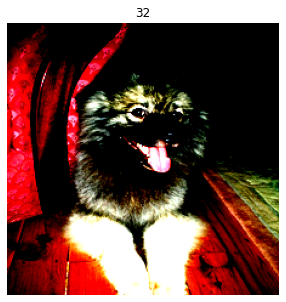

In [40]:
show_image(img, title=label)

In [119]:
len(train_ds), len(valid_ds)

(3614, 904)

In [120]:
batch_size  = 32
shuffle     = True
num_workers = 2

#create dataloader
dl_train    = DataLoader(train_ds,
                         bs=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True,
                         pin_memory=True, 
                         shufle=shuffle)


dl_valid    = DataLoader(valid_ds,
                         bs=batch_size * 2, #  
                         num_workers=num_workers, 
                         drop_last=False,
                         pin_memory=True, 
                         shufle=False)

#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')

In [121]:

#lets get one batch
x, y = dls.one_batch()

In [122]:
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 5. Building a Model

In [123]:
#https://pytorch.org/docs/stable/torchvision/models.html
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [124]:
#diffrence between them  
import torchvision.models as models

```python
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet = models.mobilenet_v2()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()
```

In [139]:
#lets take a simple model 
#pretarined means that we will load model with imagnet weights
animal_model = models.resnet18(pretrained=True)

In [140]:
animal_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

this model is trained on `imagenet` which has `1000` clases. In our case we have 37 classes. So we only have to modify last layer so the output is `37`

In [141]:
num_classes = len(int_to_label); num_classes

37

In [142]:
animal_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [143]:
nn.Linear(512, num_classes)

Linear(in_features=512, out_features=37, bias=True)

In [144]:
animal_model.fc  = nn.Linear(512, num_classes)

In [145]:
#lets check
animal_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 7. Training

just for convinience we will not write training loop pytorch has many good libraries which take care of training and let you focus on your experiments. We will be using `fastai` training loop

In [146]:
from fastai.vision.all import Learner, SGD

In [147]:
#define metric
def flatten_check(inp, targ):
    inp,targ = inp.contiguous().view(-1),targ.contiguous().view(-1)
    assert len(inp)==len(targ)
    return inp,targ

def accuracy(inp, targ, axis=-1):
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [148]:
#animal_model.requires_grad_ = False

In [151]:
#animal_model.fc.requires_grad_=True 

In [152]:
learn = Learner(dls, 
                animal_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

learn.fit(n_epoch=5, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.155668,0.357179,0.907080,00:23
1,0.120303,0.342668,0.908186,00:22
2,0.092925,0.333522,0.910398,00:22
3,0.073282,0.327346,0.904867,00:23
4,0.059222,0.323262,0.905973,00:22


Wow this is pretty good results for such a small model and under `2 min`. Lets see what happens if we dont use pretarined weights 

In [136]:
animal_model = models.resnet18(pretrained=False)
animal_model.fc  = nn.Linear(512, num_classes)

learn = Learner(dls, 
                animal_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

learn.fit(n_epoch=5, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.589267,3.596192,0.032080,00:22
1,3.514814,3.518568,0.063053,00:23
2,3.433485,3.528961,0.068584,00:22
3,3.334469,3.426831,0.077434,00:22
4,3.223435,3.381270,0.103982,00:23


You can see results are much much worse.. so its always good idea to use pretrained model

# Augmentations

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. https://medium.com/@ODSC/image-augmentation-for-convolutional-neural-networks-18319e1291c . We will use awesome python libraray called `albumentations` https://github.com/albumentations-team/albumentations

In [153]:
!pip install albumentations -q 

In [154]:
import albumentations as A

In [155]:
def open_image_array(fn: Path):
    img = PIL.Image.open(path/fn).convert('RGB')
    return np.array(img)

img= open_image_array(valid_df.iloc[0]['fn'])

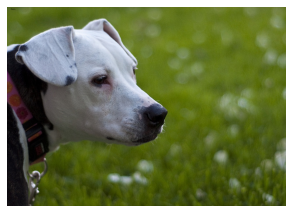

In [156]:
show_image(img)

In [157]:
transform =  A.RandomRotate90(p=1.0)

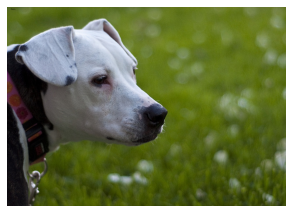

In [158]:
augmented_image = transform(image=img)['image']
show_image(augmented_image)

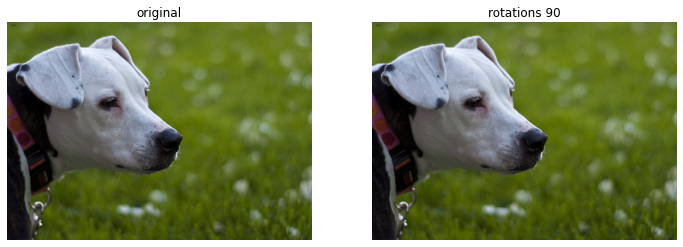

In [159]:
_,axs = plt.subplots(1,2,figsize=(12,4))
show_image(img,             ctx=axs[0], title='original');
show_image(augmented_image, ctx=axs[1], title='rotations 90');

In [160]:
#lets do buch of random augmenattions
transform = A.Compose([
        A.Resize(224, 224), 
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

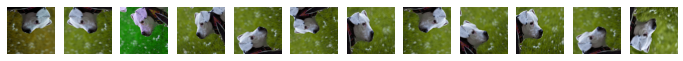

In [161]:
_,axs = plt.subplots(1,12,figsize=(12,12))
for ax in axs.flatten(): 
    augmented_image = transform(image=img)['image']
    show_image(augmented_image, ctx=ax);

### Rewriting Dataset with Augmenations

In [162]:
def open_image(fn: Path):
    img = PIL.Image.open(path/fn).convert('RGB')
    return np.array(img)
    
    
class AnimalDatset():
    def __init__(self,
                 df: pd.DataFrame, 
                 tfms: list,
                 imagenet_stats: tuple = (mean, std)):
        
        self.df         = df
        self.stats      = imagenet_stats
        self.tfms       = tfms
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path =  self.df.iloc[index]['fn']
        label    =  self.df.iloc[index]['labels']
        img      =  open_image(img_path)
        if self.tfms:  img =  self.tfms(image=img)['image']
        return img, label

In [163]:
from albumentations.pytorch import ToTensor
train_transforms  = A.Compose([
        A.Resize(224, 224), 
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225], always_apply=True),
       ToTensor()
    ])


valid_transforms  = A.Compose([
        A.Resize(224, 224),
        A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225], always_apply=True),
       ToTensor()
    ])

In [164]:

train_ds = AnimalDatset(training_df, train_transforms)
valid_ds = AnimalDatset(valid_df,    valid_transforms)

bs = 32
num_workers = 2


#create dataloader
dl_train    = DataLoader(train_ds,
                         bs=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True,
                         pin_memory=True, 
                         shufle=shuffle)


dl_valid    = DataLoader(valid_ds,
                         bs=batch_size * 2, 
                         num_workers=num_workers, 
                         drop_last=False,
                         pin_memory=True, 
                         shufle=False)

#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')




#combine train and validation dataloer
dls = DataLoaders(dl_train, dl_valid, device='cuda')

In [166]:
animal_model =      models.mobilenet_v2(pretrained=True)


In [167]:
animal_model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [168]:
animal_model.classifier[1] = nn.Linear(1280, num_classes)

In [169]:
learn = Learner(dls, 
                animal_model,
                metrics=[accuracy],
                opt_func= SGD,
                loss_func= nn.CrossEntropyLoss())

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

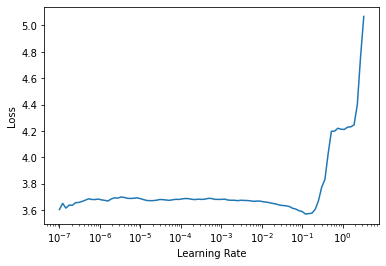

In [170]:
learn.lr_find()

In [171]:
learn.fit(n_epoch=5, lr=0.012)

epoch,train_loss,valid_loss,accuracy,time
0,2.195042,1.090992,0.787611,00:28
1,1.292232,0.665380,0.832965,00:28
2,0.955893,0.534154,0.850664,00:28
3,0.804804,0.464469,0.878319,00:28
4,0.682782,0.436330,0.875000,00:29


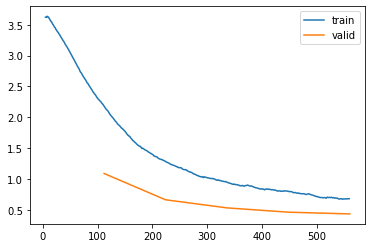

In [172]:
learn.recorder.plot_loss()

you can see our `valid loss` is smaller then `train_loss` which mean we are not overfitting right now. Since we addd a bit of augmeantions and slightly bigger model we can train for few more epoch so model can learn more effectivly

In [173]:
learn.fit(n_epoch=5, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.542199,0.406778,0.894912,00:29
1,0.506954,0.398684,0.889381,00:28
2,0.512993,0.392604,0.897124,00:28
3,0.496489,0.389447,0.894912,00:30
4,0.497226,0.388897,0.891593,00:28


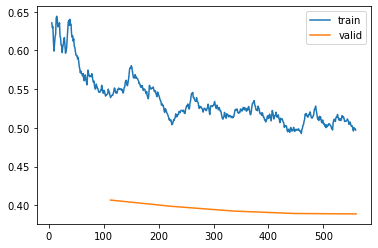

In [174]:
learn.recorder.plot_loss()

In [175]:
#lets get predictions
y_hat, y = learn.get_preds()

In [176]:
y_hat.shape, y.shape

(torch.Size([904, 37]), torch.Size([904]))

In [177]:
accuracy(y_hat, y)

tensor(0.8916)

In [179]:
predictions = y_hat.max(-1)[1]

In [180]:
predictions

tensor([16, 27, 29, 34, 16, 34, 23, 30, 10, 21, 28, 19, 22, 20, 31,  4, 22, 35,
        25, 11, 11, 34, 27, 16,  2, 14,  8, 36, 11,  8, 14, 31, 23, 36, 31, 22,
        21, 19,  0,  0, 14, 15, 16,  1, 15, 27,  9, 31, 19,  0, 15, 18, 21, 17,
        25, 17,  3, 15, 36,  6, 24,  9,  7, 32,  1,  7, 14, 23,  8, 27, 35,  2,
        25, 23, 26, 18, 17,  8, 15,  9, 22, 31,  4, 19, 21, 27, 26, 24,  1, 31,
        25, 13, 24, 30, 11, 36,  1, 35, 32, 25,  0,  6, 25,  8, 22, 25,  4,  0,
         6, 20,  4,  7, 10,  5, 16, 13, 35,  1, 26, 15, 10, 22, 18, 22, 25,  5,
        17, 10, 27, 35, 18,  6,  8,  2, 30, 28, 25, 27, 14, 17,  5, 28, 17, 30,
         3,  8, 36, 35, 27, 15, 21, 17, 30, 12, 14, 27, 16, 35,  3,  7,  3,  3,
        29, 13, 27,  6, 34, 12, 28, 32, 14, 15, 20, 30, 33, 32, 30, 10, 29,  9,
        12,  5, 21, 28, 27, 16, 16,  7,  3, 24, 25, 35, 23, 10, 13, 28,  4,  5,
        18,  7, 19, 21, 28,  5, 29,  8,  6, 28, 35, 23, 31,  0, 26, 30, 16,  5,
         4, 13, 17,  4,  6,  4, 20, 14, 